# OPTIONAL Workbook for Homework #8

You are welcome to work on a local version of a notebook and upload it for this assignment.

This workspace is here if you'd rather not have to install all necessary packages locally.

You can download any json files to your local computer to add them to your jekyll page.

To download, you can right-click on the file and hit download.  For example, with the following code:

```python
from vega_datasets import data
import altair as alt

source = data.cars()
source.rename(columns={"Miles_per_Gallon":"Miles per Gallon"}, 
              inplace=True)


chart = alt.Chart(source).mark_circle(size=60).encode(
    x='Horsepower',
    y='Miles per Gallon',
    color='Origin',
    tooltip=['Name', 'Origin', 'Horsepower', 'Miles per Gallon']
).interactive()

chart.properties(width='container').save("cars.json")
```

You can download from the side bar like this:

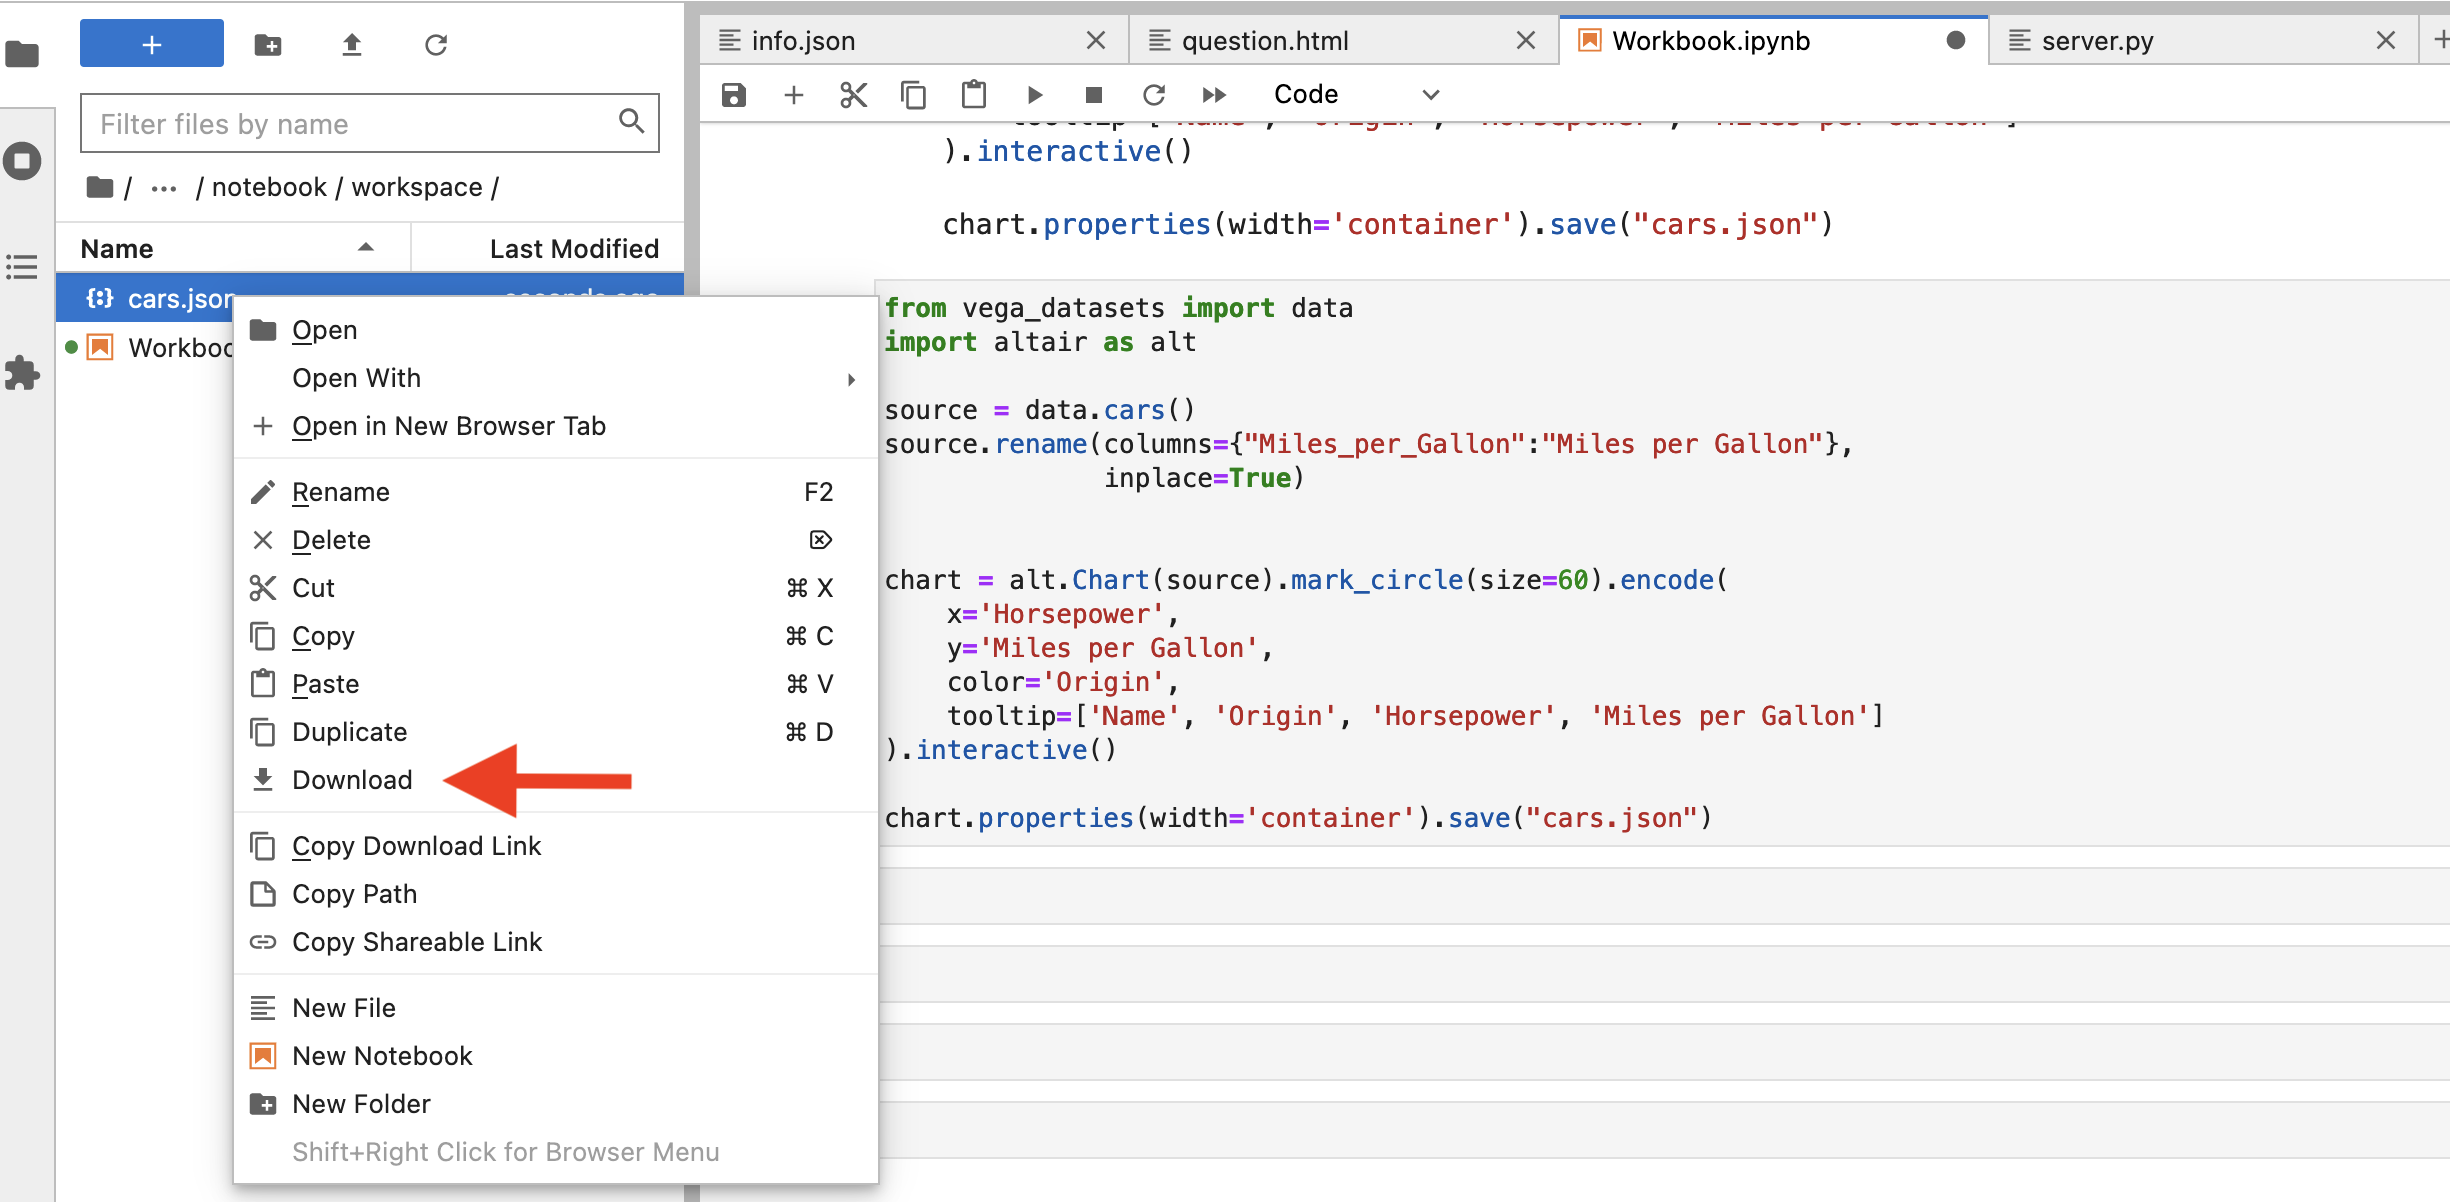

In [2]:
import pandas as pd
import altair as alt
import numpy as np

# Load the UFO data without header
url = 'https://raw.githubusercontent.com/UIUC-iSchool-DataViz/is445_data/main/ufo-scrubbed-geocoded-time-standardized-00.csv'
df_ufo = pd.read_csv(url, header=None)

# Assign proper column names based on typical UFO dataset structure
df_ufo.columns = ['datetime', 'city', 'state', 'country', 'shape', 
                  'duration_seconds', 'duration_text', 'comments', 
                  'date_posted', 'latitude', 'longitude']

# Basic exploration
print(df_ufo.shape)
print(df_ufo.columns)
print(df_ufo.head())
print(df_ufo.info())
print(df_ufo['shape'].value_counts().head(10))
print(df_ufo['country'].value_counts())

(80332, 11)
Index(['datetime', 'city', 'state', 'country', 'shape', 'duration_seconds',
       'duration_text', 'comments', 'date_posted', 'latitude', 'longitude'],
      dtype='object')
           datetime                  city state country     shape  \
0  10/10/1949 20:30            san marcos    tx      us  cylinder   
1  10/10/1949 21:00          lackland afb    tx     NaN     light   
2  10/10/1955 17:00  chester (uk/england)   NaN      gb    circle   
3  10/10/1956 21:00                  edna    tx      us    circle   
4  10/10/1960 20:00               kaneohe    hi      us     light   

   duration_seconds duration_text  \
0            2700.0    45 minutes   
1            7200.0       1-2 hrs   
2              20.0    20 seconds   
3              20.0      1/2 hour   
4             900.0    15 minutes   

                                            comments date_posted   latitude  \
0  This event took place in early fall around 194...   4/27/2004  29.883056   
1  1949 Lackland 

In [3]:
import pandas as pd
import altair as alt
import numpy as np

# Disable max rows for large dataset
alt.data_transformers.disable_max_rows()

# Load the UFO data
url = 'https://raw.githubusercontent.com/UIUC-iSchool-DataViz/is445_data/main/ufo-scrubbed-geocoded-time-standardized-00.csv'
df_ufo = pd.read_csv(url, header=None)

# Assign proper column names
df_ufo.columns = ['datetime', 'city', 'state', 'country', 'shape', 
                  'duration_seconds', 'duration_text', 'comments', 
                  'date_posted', 'latitude', 'longitude']

# DATA CLEANING AND TRANSFORMATIONS

# 1. Parse datetime and extract year
df_ufo['datetime'] = pd.to_datetime(df_ufo['datetime'], format='%m/%d/%Y %H:%M', errors='coerce')
df_ufo['year'] = df_ufo['datetime'].dt.year

# 2. Filter for US only
df_us = df_ufo[df_ufo['country'] == 'us'].copy()

# 3. Remove rows with missing essential data
df_us = df_us.dropna(subset=['latitude', 'longitude', 'shape', 'year'])

# 4. Filter reasonable lat/long for continental US + Alaska + Hawaii
df_us = df_us[(df_us['latitude'] >= 20) & (df_us['latitude'] <= 72) & 
              (df_us['longitude'] >= -180) & (df_us['longitude'] <= -65)]

# 5. Filter for years with reasonable data (after 1950)
df_us = df_us[df_us['year'] >= 1950]

# 6. Get top 10 most common shapes for cleaner visualization
top_shapes = df_us['shape'].value_counts().head(10).index.tolist()
df_us_top_shapes = df_us[df_us['shape'].isin(top_shapes)]

print(f"Cleaned data: {len(df_us)} US sightings")
print(f"Date range: {df_us['year'].min()} - {df_us['year'].max()}")
print(f"Top shapes: {top_shapes}")

Cleaned data: 63410 US sightings
Date range: 1950 - 2014
Top shapes: ['light', 'triangle', 'circle', 'fireball', 'unknown', 'other', 'sphere', 'disk', 'oval', 'formation']


In [4]:
# PLOT 1: Geographic scatter plot of UFO sightings in the US
# Sample data to avoid overplotting (use ~5000 points for better performance)
df_sample = df_us.sample(n=5000, random_state=42)

plot1 = alt.Chart(df_sample).mark_circle(
    opacity=0.3,
    size=10
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color=alt.Color('shape:N', 
                    scale=alt.Scale(scheme='category20'),
                    legend=alt.Legend(title='UFO Shape')),
    tooltip=['city:N', 'state:N', 'shape:N', 'year:Q', 'duration_text:N']
).properties(
    width=800,
    height=500,
    title='UFO Sightings Across the United States (Sample of 5,000)'
).project(
    type='albersUsa'
)

plot1

alt.Chart(...)

In [5]:
# PLOT 2: Interactive time series of sightings over time by shape
# Aggregate data by year and shape
df_time = df_us_top_shapes.groupby(['year', 'shape']).size().reset_index(name='count')

# Create selection dropdown for shape
shape_selection = alt.selection_point(
    fields=['shape'],
    bind=alt.binding_select(
        options=[None] + top_shapes,
        labels=['All Shapes'] + top_shapes,
        name='Select UFO Shape: '
    ),
    value='light'
)

plot2 = alt.Chart(df_time).mark_line(
    point=True,
    strokeWidth=2
).encode(
    x=alt.X('year:Q', 
            title='Year',
            scale=alt.Scale(domain=[1950, 2014])),
    y=alt.Y('count:Q', 
            title='Number of Sightings'),
    color=alt.condition(
        shape_selection,
        alt.Color('shape:N', 
                  scale=alt.Scale(scheme='category10'),
                  legend=alt.Legend(title='UFO Shape')),
        alt.value('lightgray')
    ),
    opacity=alt.condition(shape_selection, alt.value(1), alt.value(0.2)),
    tooltip=['year:Q', 'shape:N', 'count:Q']
).add_params(
    shape_selection
).properties(
    width=700,
    height=400,
    title='UFO Sightings Over Time by Shape (1950-2014)'
)

plot2

alt.Chart(...)

In [6]:
# Save both plots as JSON files
plot1.save('ufo_map.json')
plot2.save('ufo_timeseries.json')

print("Both plots saved successfully!")
print("- ufo_map.json")
print("- ufo_timeseries.json")

Both plots saved successfully!
- ufo_map.json
- ufo_timeseries.json
